In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import pyspark.sql.functions as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [10]:
df_border = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/user/border.csv")
df_counties = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/user/us-counties.csv")

In [11]:
df_counties = df_counties.select(col('date').cast(DateType()).alias('date'), 'county', 'state_name', 'confirmed_cases', 'deaths')

In [12]:
df_us = df_counties.groupBy('date').agg(F.sum('confirmed_cases').alias('confirmed_cases'), F.sum('deaths').alias('deaths'))

In [13]:
window = Window.partitionBy().orderBy('date')
df_us_cl = df_us.withColumn('confirmed_last', lag('confirmed_cases', 1).over(window))
df_us_nc = df_us_cl.withColumn('new_confirmed', df_us_cl['confirmed_cases'] - df_us_cl['confirmed_last'])
df_us_dl = df_us_nc.withColumn('deaths_last', lag('deaths', 1).over(window))
df_us_nd = df_us_dl.withColumn('new_deaths', df_us_dl['deaths'] - df_us_dl['deaths_last'])
df_us_final = df_us_nd.select('date', 'new_confirmed', 'new_deaths')
df_us_final.show(10)

+----------+-------------+----------+
|      date|new_confirmed|new_deaths|
+----------+-------------+----------+
|2020-01-21|         null|      null|
|2020-01-22|            0|         0|
|2020-01-23|            0|         0|
|2020-01-24|            1|         0|
|2020-01-25|            1|         0|
|2020-01-26|            2|         0|
|2020-01-27|            0|         0|
|2020-01-28|            0|         0|
|2020-01-29|            0|         0|
|2020-01-30|            1|         0|
+----------+-------------+----------+
only showing top 10 rows



In [14]:
df_border = df_border.select('trip_direction', col('date').cast(DateType()).alias('date'), 'percent_of_normal_volume')
df_border.show(10)

+--------------+----------+------------------------+
|trip_direction|      date|percent_of_normal_volume|
+--------------+----------+------------------------+
|  Canada to US|2020-03-22|                      88|
|  US to Mexico|2020-03-22|                      90|
|  US to Canada|2020-03-22|                      90|
|  Mexico to US|2020-03-22|                      97|
|  US to Canada|2020-10-22|                      98|
|  US to Mexico|2020-10-22|                     116|
|  Mexico to US|2020-10-22|                     104|
|  Canada to US|2020-10-22|                     100|
|  Canada to US|2020-11-03|                     100|
|  US to Canada|2020-11-03|                     100|
+--------------+----------+------------------------+
only showing top 10 rows



In [16]:
df_border_avg = df_border.groupBy('date').agg(F.avg('percent_of_normal_volume').alias('percent_of_normal_volume')).orderBy('date')
df_border_avg.show(10)

+----------+------------------------+
|      date|percent_of_normal_volume|
+----------+------------------------+
|2020-03-16|                   77.25|
|2020-03-17|                  103.75|
|2020-03-18|                   100.0|
|2020-03-19|                  102.25|
|2020-03-20|                   98.25|
|2020-03-21|                   96.75|
|2020-03-22|                   91.25|
|2020-03-23|                  102.25|
|2020-03-24|                   93.25|
|2020-03-25|                   91.75|
+----------+------------------------+
only showing top 10 rows



In [17]:
df_border_joined = df_border_avg.join(df_us_final, 'date')
df_border_joined.show(10)

+----------+------------------------+-------------+----------+
|      date|percent_of_normal_volume|new_confirmed|new_deaths|
+----------+------------------------+-------------+----------+
|2020-03-16|                   77.25|          907|        23|
|2020-03-17|                  103.75|         1399|        26|
|2020-03-18|                   100.0|         2444|        45|
|2020-03-19|                  102.25|         4043|        50|
|2020-03-20|                   98.25|         5619|        65|
|2020-03-21|                   96.75|         6516|        83|
|2020-03-22|                   91.25|         8545|        98|
|2020-03-23|                  102.25|        10432|       121|
|2020-03-24|                   93.25|        10433|       206|
|2020-03-25|                   91.75|        14634|       269|
+----------+------------------------+-------------+----------+
only showing top 10 rows



In [18]:
df_border_pd = df_border_joined.toPandas()

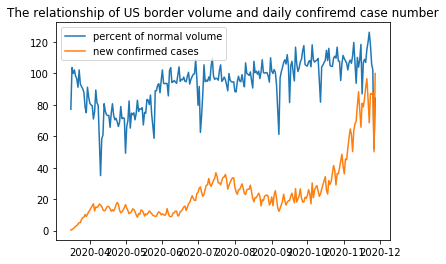

In [19]:
df = df_border_pd
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of US border volume and daily confiremd case number')
plt.show()